In [84]:
import pandas as pd
from pathlib import Path

# Import Data
We need to concatenate all readings from all csvs into a single DataFrame.

In [85]:
csv_files = list(Path('/content/measurements/').glob('*.csv'))
dfs = []

for csv_file in csv_files:
    df_temp = pd.read_csv(csv_file)
    dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)
print(f"Successfully loaded and concatenated {len(csv_files)} CSV files into a single DataFrame.")
print(f"The final DataFrame has {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

Successfully loaded and concatenated 54 CSV files into a single DataFrame.
The final DataFrame has 1883625 rows and 5 columns.


,timestamp_iso8601,sensor,quantity,value,unit
0,2025-10-01T00:00:34Z,bme280,temperature_c,27.908127,degC
1,2025-10-01T00:00:34Z,bme280,pressure_pa,101142.351562,Pa
2,2025-10-01T00:00:34Z,bme280,humidity_pct,74.104507,pct
3,2025-10-01T00:00:34Z,lm393,is_raining,0.000000,NaN
4,2025-10-01T00:00:34Z,veml7700,lux_lx,0.000000,lx


In [86]:
df = df[["timestamp_iso8601", "quantity", "value"]]
df.head()

,timestamp_iso8601,quantity,value
0,2025-10-01T00:00:34Z,temperature_c,27.908127
1,2025-10-01T00:00:34Z,pressure_pa,101142.351562
2,2025-10-01T00:00:34Z,humidity_pct,74.104507
3,2025-10-01T00:00:34Z,is_raining,0.000000
4,2025-10-01T00:00:34Z,lux_lx,0.000000


# Data Pre-Processing

## Pivoting - Reformating the data into multiple columns
We make each quantity (measurement type e.g. lux, pressure, temperature) its own column, so each row will have one value per quantity instead of one row per quantity.

In [87]:
df["quantity"].value_counts()

,count
quantity,
lux_lx,379358
is_raining,379274
pressure_pa,375300
temperature_c,374949
humidity_pct,374744


In [88]:
df = df.pivot_table(values='value', index='timestamp_iso8601',
                       columns='quantity', aggfunc="mean").reset_index()
print(df.columns.name)
df.head()

quantity


quantity,timestamp_iso8601,humidity_pct,is_raining,lux_lx,pressure_pa,temperature_c
0,2025-09-04T22:13:36Z,NaN,NaN,26.342400,NaN,NaN
1,2025-09-04T22:13:37Z,64.752380,NaN,NaN,100963.773438,29.042791
2,2025-09-04T22:13:43Z,64.420753,0.0,27.417599,100968.562500,29.022619
3,2025-09-04T22:13:52Z,NaN,0.0,NaN,NaN,NaN
4,2025-09-04T22:13:53Z,64.489609,NaN,NaN,100961.906250,28.982277


In [89]:
df.columns.name = None

In [90]:
df = df.drop(["is_raining"], axis=1)
df.head()

,timestamp_iso8601,humidity_pct,lux_lx,pressure_pa,temperature_c
0,2025-09-04T22:13:36Z,NaN,26.342400,NaN,NaN
1,2025-09-04T22:13:37Z,64.752380,NaN,100963.773438,29.042791
2,2025-09-04T22:13:43Z,64.420753,27.417599,100968.562500,29.022619
3,2025-09-04T22:13:52Z,NaN,NaN,NaN,NaN
4,2025-09-04T22:13:53Z,64.489609,NaN,100961.906250,28.982277


In [91]:
len(df)

1080214

In [92]:
df.head()

,timestamp_iso8601,humidity_pct,lux_lx,pressure_pa,temperature_c
0,2025-09-04T22:13:36Z,NaN,26.342400,NaN,NaN
1,2025-09-04T22:13:37Z,64.752380,NaN,100963.773438,29.042791
2,2025-09-04T22:13:43Z,64.420753,27.417599,100968.562500,29.022619
3,2025-09-04T22:13:52Z,NaN,NaN,NaN,NaN
4,2025-09-04T22:13:53Z,64.489609,NaN,100961.906250,28.982277


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080214 entries, 0 to 1080213
Data columns (total 5 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   timestamp_iso8601  1080214 non-null  object 
 1   humidity_pct       374604 non-null   float64
 2   lux_lx             379263 non-null   float64
 3   pressure_pa        375161 non-null   float64
 4   temperature_c      374830 non-null   float64
dtypes: float64(4), object(1)
memory usage: 41.2+ MB


## Resampling - Handling small gaps between sensor readings
Each quantity is captured by a different sensor. Since the data is captured every 10 seconds, there may be very slight differences (seconds or milliseconds) between when each sensor actually captures its information. This results in readings that represent the same 10 second period appear as different rows. In reality, they should represent the same instance. **Resampling** organizes the data into 30 minute chunks, and takes the average of each value within that 30 minute chunk, thus consolidating them into a single row.

In [94]:
df["timestamp_iso8601"] = pd.to_datetime(df["timestamp_iso8601"], format='mixed')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080214 entries, 0 to 1080213
Data columns (total 5 columns):
 #   Column             Non-Null Count    Dtype              
---  ------             --------------    -----              
 0   timestamp_iso8601  1080214 non-null  datetime64[ns, UTC]
 1   humidity_pct       374604 non-null   float64            
 2   lux_lx             379263 non-null   float64            
 3   pressure_pa        375161 non-null   float64            
 4   temperature_c      374830 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(4)
memory usage: 41.2 MB


In [95]:
# In the original dataset, the sensor readings may have come in at very slightly
# different times, i.e. 1 second apart. But each of these should have technically
# been one instance. So we resample, to get the average of each value within the
# specified resample time.

df = df.set_index("timestamp_iso8601").resample('30min').mean()
df.head()

,humidity_pct,lux_lx,pressure_pa,temperature_c
timestamp_iso8601,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615


In [96]:
len(df)

3211

In [97]:
df = df.sort_values("timestamp_iso8601")
df.head()

,humidity_pct,lux_lx,pressure_pa,temperature_c
timestamp_iso8601,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615


## Interpolation - Handling gaps in the continuous time data
After resampling, there would have been periods where the board was turned off. This results in gaps in the data. Interpolation uses the nearest values to the missing times to fill them.

In [98]:
df.loc["2025-09-04 22:00:00+00:00":"2025-09-05 00:00:00+00:00"]

,humidity_pct,lux_lx,pressure_pa,temperature_c
timestamp_iso8601,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615


In [99]:
print(f"Data ranges from {df.index[0]} to {df.index[-1]} and we have {len(df)} instances")

Data ranges from 2025-09-04 22:00:00+00:00 to 2025-11-10 19:00:00+00:00 and we have 3211 instances


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3211 entries, 2025-09-04 22:00:00+00:00 to 2025-11-10 19:00:00+00:00
Freq: 30min
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   humidity_pct   2340 non-null   float64
 1   lux_lx         2339 non-null   float64
 2   pressure_pa    2340 non-null   float64
 3   temperature_c  2340 non-null   float64
dtypes: float64(4)
memory usage: 254.5 KB


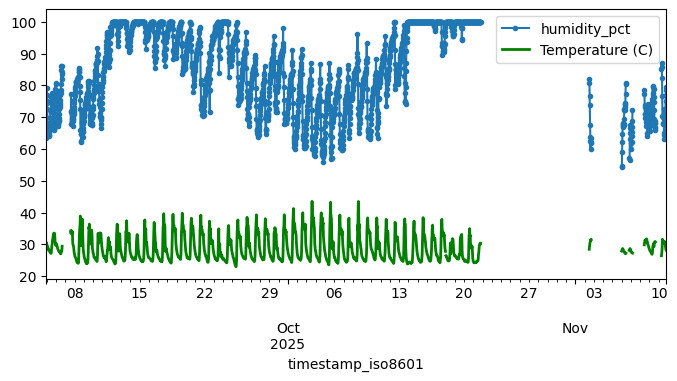

In [101]:
# Plotting
import matplotlib.pyplot as plt

# The last 5-day period
ax = df["humidity_pct"].plot(grid=True, marker='.', figsize=(8, 3.5))

df["temperature_c"].plot(
    ax=ax, color='green', linewidth=2, label="Temperature (C)"
)

# Add a legend to distinguish them
ax.legend()

In [102]:
# The gaps indicate times the board was off

In [103]:
df = df.interpolate(method="linear")
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3211 entries, 2025-09-04 22:00:00+00:00 to 2025-11-10 19:00:00+00:00
Freq: 30min
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   humidity_pct   3211 non-null   float64
 1   lux_lx         3211 non-null   float64
 2   pressure_pa    3211 non-null   float64
 3   temperature_c  3211 non-null   float64
dtypes: float64(4)
memory usage: 254.5 KB


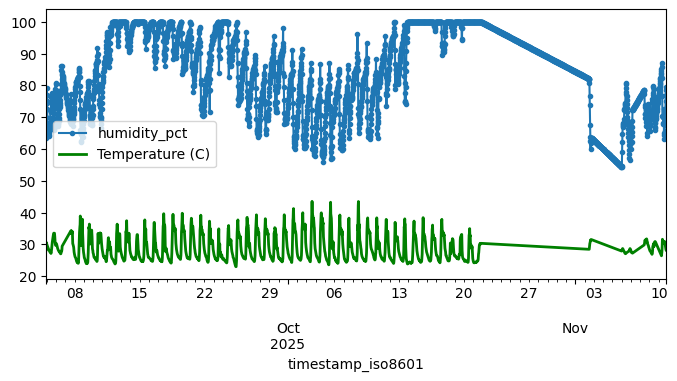

In [104]:
# The last 5-day period
ax = df["humidity_pct"].plot(grid=True, marker='.', figsize=(8, 3.5))

df["temperature_c"].plot(
    ax=ax, color='green', linewidth=2, label="Temperature (C)"
)
# Add a legend to distinguish them
ax.legend()

# Feature Engineering
We include the following features:
1. `sine_hour` - This captures the cyclical nature of the hour of the day. e.g. when taking the sine of the hour of the day, 23:00 is closer to 00:00 as it should be.
2. `cos_hour` - Similar to the above.
3. `temperature_delta` -  The difference between the temperature at the current timestamp and the timestamp immediately before.
4. `temp_mean_6h` - The average temperature over the past 6 hours at this current timestamp.
5. `temp_humidity_6h` - The average humidity over the past 6 hours at this current timestamp.

In [105]:
hour_of_day = df.index.hour
hour_of_day

Index([22, 22, 23, 23,  0,  0,  1,  1,  2,  2,
       ...
       14, 15, 15, 16, 16, 17, 17, 18, 18, 19],
      dtype='int32', name='timestamp_iso8601', length=3211)

In [106]:
import numpy as np

df["sine_hour"] = np.sin(2 * np.pi * hour_of_day / 24)
df["cos_hour"] = np.cos(2 * np.pi * hour_of_day / 24)
df.head()

,humidity_pct,lux_lx,pressure_pa,temperature_c,sine_hour,cos_hour
timestamp_iso8601,,,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483,-0.500000,0.866025
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315,-0.500000,0.866025
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943,-0.258819,0.965926
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356,-0.258819,0.965926
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615,0.000000,1.000000


In [107]:
df["delta_temperature"] = df["temperature_c"] - df["temperature_c"].shift(1)
df.head()

,humidity_pct,lux_lx,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature
timestamp_iso8601,,,,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483,-0.500000,0.866025,NaN
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315,-0.500000,0.866025,0.174832
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943,-0.258819,0.965926,2.232628
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356,-0.258819,0.965926,-0.260587
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615,0.000000,1.000000,-0.584741


In [108]:
# Since the first row will be null, we fill it with the mean for this column
df['delta_temperature'].fillna(df['delta_temperature'].mean(), inplace=True)
df.head()

/tmp/ipython-input-1216042316.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['delta_temperature'].fillna(df['delta_temperature'].mean(), inplace=True)


,humidity_pct,lux_lx,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature
timestamp_iso8601,,,,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483,-0.500000,0.866025,0.000023
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315,-0.500000,0.866025,0.174832
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943,-0.258819,0.965926,2.232628
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356,-0.258819,0.965926,-0.260587
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615,0.000000,1.000000,-0.584741


In [109]:
df["temp_mean_6h"] = df["temperature_c"].rolling(window=12, min_periods=1).mean()
df.head()

,humidity_pct,lux_lx,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature,temp_mean_6h
timestamp_iso8601,,,,,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483,-0.500000,0.866025,0.000023,28.172483
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315,-0.500000,0.866025,0.174832,28.259899
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943,-0.258819,0.965926,2.232628,29.033247
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356,-0.258819,0.965926,-0.260587,29.354774
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615,0.000000,1.000000,-0.584741,29.430743


In [110]:
df["humidity_mean_6h"] = df["humidity_pct"].rolling(window=12, min_periods=1).mean()
df.head()

,humidity_pct,lux_lx,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature,temp_mean_6h,humidity_mean_6h
timestamp_iso8601,,,,,,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483,-0.500000,0.866025,0.000023,28.172483,63.341935
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315,-0.500000,0.866025,0.174832,28.259899,66.644727
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943,-0.258819,0.965926,2.232628,29.033247,69.562658
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356,-0.258819,0.965926,-0.260587,29.354774,71.393847
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615,0.000000,1.000000,-0.584741,29.430743,72.973036


## Normalizing

In [111]:
df.describe()

,humidity_pct,lux_lx,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature,temp_mean_6h,humidity_mean_6h
count,3211.000000,3211.000000,3211.000000,3211.000000,3.211000e+03,3.211000e+03,3211.000000,3211.000000,3211.000000
mean,84.561803,3664.168166,101076.589168,29.014012,1.280657e-03,-8.324611e-04,0.000023,29.013415,84.554263
std,12.887869,5893.033295,157.332053,3.475414,7.070102e-01,7.074219e-01,0.843607,2.929927,12.570577
min,54.362780,0.000000,100635.793644,22.989888,-1.000000e+00,-1.000000e+00,-4.365562,23.692777,54.666894
25%,74.751893,0.000000,100963.057363,25.996689,-7.071068e-01,-7.071068e-01,-0.207278,26.548734,74.628144
50%,86.173429,515.948858,101080.051792,28.818711,1.224647e-16,-1.836970e-16,-0.023071,28.981914,85.965390
75%,96.672447,5009.655660,101187.495746,30.531140,7.071068e-01,7.071068e-01,0.042708,30.525371,96.425297
max,100.000000,28891.834070,101492.141722,43.539995,1.000000e+00,1.000000e+00,4.937021,39.408742,100.000000


In [112]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Identify numerical columns to scale, excluding 'temperature_c'
columns_to_scale = df.select_dtypes(include='number').columns.drop('temperature_c')

df[columns_to_scale] = scaler.fit_transform(
    df[columns_to_scale]
)

In [113]:
df.describe()

,humidity_pct,lux_lx,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature,temp_mean_6h,humidity_mean_6h
count,3.211000e+03,3211.000000,3.211000e+03,3211.000000,3.211000e+03,3.211000e+03,3.211000e+03,3.211000e+03,3.211000e+03
mean,-1.053312e-15,0.000000,5.747187e-14,29.014012,-3.346920e-17,2.766049e-17,8.298148e-19,-1.548988e-16,-1.168379e-15
std,1.000156e+00,1.000156,1.000156e+00,3.475414,1.000156e+00,1.000156e+00,1.000156e+00,1.000156e+00,1.000156e+00
min,-2.343578e+00,-0.621876,-2.802126e+00,22.989888,-1.416439e+00,-1.412627e+00,-5.175713e+00,-1.816246e+00,-2.377936e+00
25%,-7.612925e-01,-0.621876,-7.217187e-01,25.996689,-1.002104e+00,-9.985333e-01,-2.457704e-01,-8.413401e-01,-7.897541e-01
50%,1.250693e-01,-0.534311,2.201181e-02,28.818711,-1.811652e-03,1.176937e-03,-2.738018e-02,-1.075328e-02,1.122739e-01
75%,9.398396e-01,0.228354,7.050302e-01,30.531140,9.984807e-01,1.000887e+00,5.060541e-02,5.161191e-01,9.444979e-01
max,1.198072e+00,4.281597,2.641657e+00,43.539995,1.412815e+00,1.414981e+00,5.853162e+00,3.548534e+00,1.228913e+00


# Creating the Datasets used by the Model

## Define Input Window Size and Prediction Window Size
We want to use the previous 24 hours of data to predict the next 12 hours of temperatures.

In [114]:
sample_size_in_hrs = 0.5 # we resampled to 30-min chunks
window_size_in_hrs = 24

# since each instance is a 30-min period, and we want a 24hr window
seq_length = int(window_size_in_hrs / sample_size_in_hrs)

## Train, Test Split
We use 80% of the data to train. Then the remaining 20% is then split into equal 10% segments. **No shuffling is done as the time series data needs to stay in chronological order**.

In [115]:
from sklearn.model_selection import train_test_split

# First split: 80% and 20%
df_train, df_temp = train_test_split(df, test_size=0.2,
                                     random_state=42, shuffle=False)

# Second split: split the remaining 20% into two 10% parts
df_valid, df_test = train_test_split(df_temp, test_size=0.5,
                                     random_state=42, shuffle=False)

print(f"Train: {len(df_train)}")
print(f"Valid: {len(df_valid)}")
print(f"Test: {len(df_test)}")


Train: 2568
Valid: 321
Test: 322


In [116]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2568 entries, 2025-09-04 22:00:00+00:00 to 2025-10-28 09:30:00+00:00
Freq: 30min
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   humidity_pct       2568 non-null   float64
 1   lux_lx             2568 non-null   float64
 2   pressure_pa        2568 non-null   float64
 3   temperature_c      2568 non-null   float64
 4   sine_hour          2568 non-null   float64
 5   cos_hour           2568 non-null   float64
 6   delta_temperature  2568 non-null   float64
 7   temp_mean_6h       2568 non-null   float64
 8   humidity_mean_6h   2568 non-null   float64
dtypes: float64(9)
memory usage: 200.6 KB


In [117]:
df_train.head()

,humidity_pct,lux_lx,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature,temp_mean_6h,humidity_mean_6h
timestamp_iso8601,,,,,,,,,
2025-09-04 22:00:00+00:00,-1.646756,-0.617363,-0.654586,28.172483,-0.709125,1.225567,1.646917e-19,-0.287059,-1.687721
2025-09-04 22:30:00+00:00,-1.134133,-0.614718,-0.680258,28.347315,-0.709125,1.225567,2.072485e-01,-0.257219,-1.424941
2025-09-04 23:00:00+00:00,-0.711112,-0.605343,-0.655005,30.579943,-0.367944,1.366807,2.646912e+00,0.006770,-1.192781
2025-09-04 23:30:00+00:00,-0.595567,-0.605279,-0.432934,30.319356,-0.367944,1.366807,-3.089722e-01,0.116526,-1.047085
2025-09-05 00:00:00+00:00,-0.409131,-0.605274,-0.320053,29.734615,-0.001812,1.414981,-6.932795e-01,0.142458,-0.921440


## Converting DataFrames to Timeseries Datasets

In [118]:
import tensorflow as tf

In [119]:
def split_inputs_and_targets(
    multivariable_series,
    ahead=24, # the next 24 30-minute time slots (12 hours)
    target_col=3):
  return multivariable_series[:, :-ahead], multivariable_series[:, -ahead:, target_col]

In [120]:
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    df_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 24,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)

train_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, None, 9), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>

In [121]:
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    df_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 24,
    batch_size=32
).map(split_inputs_and_targets)
valid_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, None, 9), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>

# Build and Compile the Model

## I Should Use Keras Tuner here once i get the base model to run

## Definition

In [122]:
# model = tf.keras.Sequential([
#     tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=(48, 9)),
#     tf.keras.layers.SimpleRNN(32),
#     tf.keras.layers.Dense(24)
# ])

In [123]:
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae",
#                                                              patience=10,
#                                                              restore_best_weights=True)
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

In [124]:
# model.compile(
#     loss=tf.keras.losses.Huber(),
#     optimizer=optimizer,
#     metrics=["mae"]
# )

## Training

In [125]:
# history = model.fit(
#     train_ds, validation_data=valid_ds,
#     epochs=500, callbacks=[early_stopping_cb]
# )

## Using Keras Tuner to Find Optimal Hyperparameters

In [126]:
!pip install keras_tuner --upgrade

In [127]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int('n_hidden', min_value=0, max_value=3, default=2)
    n_neurons = hp.Int('n_neurons', min_value=16, max_value=64)
    learning_rate = hp.Float('learning_rate', min_value=1e-4,
                           max_value=1e-2, sampling='log')
    optimizer = hp.Choice('optimizer', values=["sgd", "adam"])
    if optimizer == "sgd":
      optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate,
                                          momentum=0.9)
    else:
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()

    # Add an Input layer explicitly to define the input shape
    model.add(tf.keras.Input(shape=(48, 9))) # seq_length=48, num_features=9

    # List to hold configurations for the *actual* RNN layers (after the Input layer)
    rnn_layers_configs = []

    # First RNN layer (conceptually, after the Input layer)
    rnn_layers_configs.append({'units': 32})

    # Additional hidden RNN layers
    for _ in range(n_hidden):
        rnn_layers_configs.append({'units': n_neurons})

    # Add RNN layers to the model, setting return_sequences=False only for the last one
    for i, config in enumerate(rnn_layers_configs):
        is_last_rnn = (i == len(rnn_layers_configs) - 1)
        model.add(tf.keras.layers.SimpleRNN(config['units'],
                                            return_sequences=not is_last_rnn))

    # Output layer
    model.add(tf.keras.layers.Dense(24))

    model.compile(
        loss=tf.keras.losses.Huber(),
        optimizer=optimizer,
        metrics=["mae"])

    return model

In [128]:
random_search_tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=5,
    overwrite=True,
    directory="rnn_model",
    project_name="random_search_rnn",
    seed=42
)

In [129]:
random_search_tuner.search(train_ds, epochs=20, validation_data=valid_ds)

Trial 5 Complete [00h 01m 11s]
val_mae: 22.510456085205078

Best val_mae So Far: 0.865134596824646
Total elapsed time: 00h 06m 32s


In [130]:
model = random_search_tuner.get_best_models(num_models=1)[0]
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 48, 32)         │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 27)             │         1,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           672 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,636 (14.20 KB)

 Trainable params: 3,636 (14.20 KB)

 Non-trainable params: 0 (0.00 B)

In [131]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 2 summary
Hyperparameters:
n_hidden: 1
n_neurons: 27
learning_rate: 0.00905127409782462
optimizer: adam
Score: 0.865134596824646


# Training the Best Model Found by the Tuner

# Using the Model to Make Predictions

In [132]:
def predict_12_hours(model, input_df, seq_length, start_idx, target_col_name,
                     target_col_idx, window_size_in_hrs, scaler):
  X = input_df.to_numpy()[np.newaxis, start_idx:start_idx+seq_length]
  print(f"Shape of Input Data: {X.shape}")

  Y_pred = model.predict(X)[0]
  print(f"Model's Original Prediction (Normalized): {Y_pred}")

  actual_next_12_hrs = input_df[start_idx+seq_length:
                                start_idx+seq_length+window_size_in_hrs][target_col_name].to_numpy()
  print(f"Actual Next 12 Hours: {actual_next_12_hrs}")

  # Calculating the predictions in degrees celcius
  temp_mean = scaler.mean_[target_col_idx]
  temp_std = scaler.scale_[target_col_idx]

  print(temp_mean, temp_std)

  Y_pred_deg = (Y_pred * temp_std) + temp_mean
  actual_next_12_hr_deg = (actual_next_12_hrs * temp_std) + temp_mean

  for i in range(window_size_in_hrs):
    model_pred_in_deg = Y_pred_deg[i]
    actual_in_deg = actual_next_12_hr_deg[i]
    pred_error = model_pred_in_deg - actual_in_deg

    print(f"{(i+1) * 30} MINUTES INTO THE FUTURE!")
    print(f"Model Prediction: {model_pred_in_deg} degrees celcius.")
    print(f"Actual Value: {actual_in_deg} degrees celcius.")
    print(f"Prediction Error: {pred_error} degrees celcius.")
    print('*'*20)

  return Y_pred_deg, actual_next_12_hr_deg

In [133]:
Y_pred_deg, actual_val_deg = predict_12_hours(model, df_valid, seq_length, 0, "temperature_c",
                 3, window_size_in_hrs, scaler)

Shape of Input Data: (1, 48, 9)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
Model's Original Prediction (Normalized): [28.600098 28.595652 28.541851 28.433613 28.57294  28.510736 28.41706
 28.38624  28.441467 28.408504 28.36786  28.416508 28.425621 28.363184
 28.332602 28.357428 28.434244 28.437466 28.425581 28.437023 28.506243
 28.484066 28.492176 28.584269]
Actual Next 12 Hours: [29.12654608 29.12320005 29.11985402 29.11650799 29.11316196 29.10981593
 29.1064699  29.10312387 29.09977784 29.09643181 29.09308578 29.08973974
 29.08639371 29.08304768 29.07970165 29.07635562 29.07300959 29.06966356
 29.06631753 29.0629715  29.05962547 29.05627944 29.05293341 29.04958738]
0.001280657177275303 0.7069001289249607
30 MINUTES INTO THE FUTURE!
Model Prediction: 20.218693377646865 degrees celcius.
Actual Value: 20.5908398381588 degrees celcius.
Prediction Error: -0.3721464605119351 degrees celcius.
********************
60 MINUTES INTO THE FUTURE!
Model Prediction: 20.215550478704827 degrees celcius.


# Evaluating the model on the test set

In [134]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 322 entries, 2025-11-04 02:30:00+00:00 to 2025-11-10 19:00:00+00:00
Freq: 30min
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   humidity_pct       322 non-null    float64
 1   lux_lx             322 non-null    float64
 2   pressure_pa        322 non-null    float64
 3   temperature_c      322 non-null    float64
 4   sine_hour          322 non-null    float64
 5   cos_hour           322 non-null    float64
 6   delta_temperature  322 non-null    float64
 7   temp_mean_6h       322 non-null    float64
 8   humidity_mean_6h   322 non-null    float64
dtypes: float64(9)
memory usage: 25.2 KB


In [135]:
test_ds = tf.keras.utils.timeseries_dataset_from_array(
    df_test.to_numpy(),
    targets=None,
    sequence_length=seq_length + 24,  # same as in training
    batch_size=32
).map(split_inputs_and_targets)


In [136]:
results = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.3481 - mae: 0.6786


In [137]:
test_mae = results[1]
test_mae

0.9519475698471069

In [138]:
test_mae_deg = (test_mae * scaler.scale_[3])
test_mae_deg

np.float64(0.6729318598547229)

# Preparing the Model for Deployment on the Embedded Board

## Quantizing, Pruning and Saving the TFLite Model

In [139]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]


# # Fix for TensorArray ops
# converter.target_spec.supported_ops = [
#     tf.lite.OpsSet.TFLITE_BUILTINS,
#     tf.lite.OpsSet.SELECT_TF_OPS
# ]
# converter._experimental_lower_tensor_list_ops = False


# quantized_model = converter.convert()
# with open('quantized_rnn_model.tflite', 'wb') as f:
#   f.write(quantized_model)

In [140]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Define a representative dataset for full integer quantization
def representative_dataset():
    for x, y in train_ds.take(100):  # Use a small subset of the training data
        yield [tf.cast(x, tf.float32)] # Yield input data as a list of Tensors

converter.representative_dataset = representative_dataset

# Fix for TensorArray ops as suggested by the error
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False

# Removed inference_input_type and inference_output_type as they are for full integer quantization
# and are causing conflict with SELECT_TF_OPS

quantized_model = converter.convert()
with open('quantized_rnn_model.tflite', 'wb') as f:
  f.write(quantized_model)

Saved artifact at '/tmp/tmphojzobh6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 9), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 24), dtype=tf.float32, name=None)
Captures:
  136451195726224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136451195726032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136451195723536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136451083605712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136451083606096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136451083605904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136451106532880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136451083603792: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


## Reload the TFLite Model

In [152]:
# Load the TFLite model
# interpreter = tf.lite.Interpreter(model_path="quantized_rnn_model.tflite")
interpreter = tf.lite.Interpreter(model_path="quantized_rnn_model.tflite")
interpreter.allocate_tensors()

# Get input and output details (optional)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Model loaded successfully!")
print("Input details:", input_details)
print("Output details:", output_details)

Model loaded successfully!
Input details: [{'name': 'serving_default_keras_tensor:0', 'index': 0, 'shape': array([ 1, 48,  9], dtype=int32), 'shape_signature': array([-1, 48,  9], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 50, 'shape': array([ 1, 24], dtype=int32), 'shape_signature': array([-1, 24], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [153]:

# Evaluating the size of the tflite model
import os

# file_path = "quantized_rnn_model.tflite"
file_path = "quantized_rnn_model.tflite"
size_in_bytes = os.path.getsize(file_path)
size_in_kb = size_in_bytes / 1024
size_in_mb = size_in_kb / 1024

print(f"Model size: {size_in_bytes} bytes ({size_in_kb:.2f} KB / {size_in_mb:.2f} MB)")


Model size: 25544 bytes (24.95 KB / 0.02 MB)


## Using the TFLite Model to Make a Prediction

In [155]:
# Prepare input (same as Keras)
X = df_valid.to_numpy()[np.newaxis, :seq_length]  # shape: (1, seq_length, features)
X = X.astype(input_details[0]['dtype'])  # match TFLite dtype

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], X)

# Run inference
interpreter.invoke()

# Get prediction
output_data = interpreter.get_tensor(output_details[0]['index'])
print("Prediction:", output_data)

Prediction: [[28.487947 28.487947 28.37579  28.37579  28.487947 28.37579  28.263632
  28.263632 28.37579  28.263632 28.263632 28.263632 28.37579  28.263632
  28.263632 28.263632 28.37579  28.263632 28.263632 28.37579  28.37579
  28.37579  28.37579  28.487947]]


## Evaluating the TFLite Model on the Test Dataset

In [156]:
df_test.head()

,humidity_pct,lux_lx,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature,temp_mean_6h,humidity_mean_6h
timestamp_iso8601,,,,,,,,,
2025-11-04 02:30:00+00:00,-1.931448,-0.613690,0.356628,30.008589,0.705502,1.225567,-0.02738,0.383027,-1.954062
2025-11-04 03:00:00+00:00,-1.935977,-0.613675,0.363262,29.985517,0.998481,1.000887,-0.02738,0.375151,-1.958705
2025-11-04 03:30:00+00:00,-1.940506,-0.613660,0.369897,29.962446,0.998481,1.000887,-0.02738,0.367275,-1.963349
2025-11-04 04:00:00+00:00,-1.945035,-0.613645,0.376531,29.939375,1.223291,0.708079,-0.02738,0.359400,-1.967992
2025-11-04 04:30:00+00:00,-1.949564,-0.613630,0.383165,29.916303,1.223291,0.708079,-0.02738,0.351524,-1.972635


In [157]:

import numpy as np

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

seq_length = 48  # or whatever your window size is
num_features = df_test.shape[1]

# Store predictions and true values
preds = []
trues = []

# Loop through test set windows
for start in range(len(df_test) - seq_length - 24 + 1):  # 24 is your prediction horizon
    X = df_test.to_numpy()[start:start+seq_length]
    X = X[np.newaxis, ...].astype(input_details[0]['dtype'])  # shape: (1, seq_length, features)
    interpreter.set_tensor(input_details[0]['index'], X)
    interpreter.invoke()
    y_pred = interpreter.get_tensor(output_details[0]['index'])[0]  # shape: (24,)
    preds.append(y_pred)
    # True values for the next 24 steps of the target column (e.g., temperature)
    y_true = df_test.iloc[start+seq_length:start+seq_length+24]['temperature_c'].to_numpy()
    trues.append(y_true)


In [158]:

preds = np.array(preds)
trues = np.array(trues)

# If you normalized your data, de-normalize predictions and trues here

mae = np.mean(np.abs(preds - trues))

In [159]:
print(f"TFLite Model Test MAE: {mae}")
print(f"TFLite Model Test MAE Degrees Celcius: {mae * scaler.scale_[3]}")

TFLite Model Test MAE: 0.9501596086216054
TFLite Model Test MAE Degrees Celcius: 0.6716679498339031
